# Import Library

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
import talib
import pandas_datareader as web
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fetch data

In [42]:
df=web.DataReader('FB',data_source='yahoo',start='2005-01-01',end='2019-12-17')

In [43]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [44]:
Close=df['Close']

# Technical Indicators

Moving Average Convergence Divergence-MACD
It is a trend following indicator that shows the relationship between two moving averages of security's price.

In [45]:
macd,macdsignal,macdhist=talib.MACD(Close,fastperiod=12,slowperiod=26,signalperiod=9)
dict={'MACD':macd,'MSIG':macdsignal}
macdata=[]
macdata=pd.DataFrame(data=dict)
macdata.dropna(inplace=True)
macdata['MACD_Signals']=macdata.apply(lambda x:1 if x['MACD']>x['MSIG'] else 0,axis=1)
n_days=len(macdata['MACD'])
Signal=macdata['MACD_Signals']
psy=[]
for d in range(0,n_days):
    if Signal[d]==1:
        psy.append(1)
    elif Signal[d]==0:
        psy.append(0)
macdata['MACD_Signal']=psy
del macdata['MACD_Signals']

In [46]:
macdata.head()

,MACD,MSIG,MACD_Signal
Date,,,
2012-07-06,0.385690,0.284100,1
2012-07-09,0.443274,0.315935,1
2012-07-10,0.427497,0.338247,1
2012-07-11,0.370379,0.344674,1
2012-07-12,0.308643,0.337468,0


In [47]:
dict={'MHIST':macdhist,'PrevMHIST':macdhist.shift(1)}
machdata=[]
machdata=pd.DataFrame(data=dict)
machdata.dropna(inplace=True)
machdata['MHIST_Signals']=machdata.apply(lambda x:1 if x['MHIST']>x['PrevMHIST'] else 0,axis=1)
n_days=len(machdata['MHIST'])
Signal=machdata['MHIST_Signals']
psy=[]
for i in range(0,n_days):
    if Signal[i]==1:
        psy.append(1)
    elif Signal[i]==0:
        psy.append(0)
machdata['MHIST_Signal']=psy
del machdata['MHIST_Signals']


# Relative Strength Index-RSI

In [48]:
rsi=talib.RSI(Close,timeperiod=14)
dict={'Close':Close,'RSI':rsi}
rsidata=[]
rsidata=pd.DataFrame(data=dict)
rsidata.dropna(inplace=True)
rsidata['rsi1']=rsidata.apply(lambda x: 1 if x['RSI']<30 else 0,axis=1)
rsidata['rsi2']=rsidata.apply(lambda x: -1 if x['RSI']>70 else 0,axis=1)
rsidata['Signs']=rsidata.apply(lambda x:x['rsi1']+x['rsi2'],axis=1)
n_days=len(rsidata['RSI'])
Signal=rsidata['Signs']
psy=[]
for d in range(0,n_days):
    if Signal[d]==1:
        psy.append(1)
    elif Signal[d]==-1:
        psy.append(0)
    elif Signal[d]==0:
        psy.append(0)
rsidata['Psycology']=psy
del rsidata['Signs']
del rsidata['rsi2']
del rsidata['rsi1']

# Classify Next Days Stock Move

In [13]:
Move=Close.shift(-1)
dict={'Close':Close,'Move':Move}
sdmdata=[]
sdmdata=pd.DataFrame(data=dict)
sdmdata.dropna(inplace=True)
sdmdata['sign']=sdmdata.apply(lambda x:1 if np.log(x['Move']/x['Close'])>0 else -1,axis=1)
n_days=len(sdmdata['Move'])
Signal=sdmdata['sign']
psy=[]
for d in range(n_days):
    if Signal[d]==1:
        psy.append(1)
    elif Signal[d]==-1:
        psy.append(0)
sdmdata['Next Week Move']=psy
del sdmdata['sign']


# Combining Technical Indicators and Next Day's Stock Move

In [49]:
Close=pd.DataFrame({'Close':Close})
NWM=pd.DataFrame({'Next Week Move':sdmdata['Next Week Move']})
MACD=pd.DataFrame({'MACD':macdata['MACD_Signal']})
MHIST=pd.DataFrame({'MHIST':machdata['MHIST_Signal']})
RSI=pd.DataFrame({'RSI':rsidata['Psycology']})

merge=pd.merge(Close,NWM,left_index=True,right_index=True,how='outer')
merge=pd.merge(merge,MACD,left_index=True,right_index=True,how='outer')
merge=pd.merge(merge,MHIST,left_index=True,right_index=True,how='outer')
df_daily=pd.merge(merge,RSI,left_index=True,right_index=True,how='outer')
df_daily.dropna(inplace=True)

In [50]:
df_daily.head()

,Close,Next Week Move,MACD,MHIST,RSI
Date,,,,,
2012-07-09,32.169998,0.0,1.0,1.0,0.0
2012-07-10,31.469999,0.0,1.0,0.0,0.0
2012-07-11,30.969999,0.0,1.0,0.0,0.0
2012-07-12,30.809999,0.0,0.0,0.0,0.0
2012-07-13,30.719999,0.0,0.0,0.0,0.0


# Splitting Data into Training and Test Set

In [51]:
X=df_daily[['MACD','MHIST','RSI']]
y=df_daily['Next Week Move']

In [52]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

# Training Model

In [53]:
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [54]:
y_pred=model.predict(X_test)
print("Accuracy score: {:.2f} %".format(accuracy_score(y_test,y_pred)*100))

Accuracy score: 52.24 %


# Strategy Analysis: Training Period

In [55]:
Traindata=df_daily[:int(len(df_daily['Close'])*0.65)]
del Traindata['Next Week Move']

In [56]:
index=Traindata[['MACD','MHIST','RSI']]
inxclose=Traindata['Close']
predictions=model.predict(index)
Traindata['Predict']=predictions
Rdata=Traindata[['Close','Predict','MACD','MHIST','RSI']]
Rdata['NextClose']=Rdata['Close'].shift(-1)
Rdata.dropna(inplace=True)


In [57]:
Rdata['Strategy Return']=Rdata.apply(lambda x:np.log(x['NextClose']/x['Close']) if x['Predict']==1 else 0,axis=1)
Total_Return=Rdata['Strategy Return'].sum()
Cum_Return=Rdata['Strategy Return'].cumsum()
print("The Total Return for the Strategy is:",Total_Return)

The Total Return for the Strategy is: 1.7512860626549462


In [58]:
Rdata['MACD Return']=Rdata.apply(lambda x:np.log(x['NextClose']/x['Close']) if x['MACD']==1 else 0.001,axis=1)
Total_MACD=Rdata['MACD Return'].sum()
Cum_MACD=Rdata['MACD Return'].cumsum()
print("The Total Return for the MACD Strategy is:",Total_MACD)

The Total Return for the MACD Strategy is: 1.1762686440529628


RSI Return

In [59]:
Rdata['RSI Return']=Rdata.apply(lambda x:np.log(x['NextClose']/x['Close']) if x['RSI']==1 else 0.001,axis=1)
Total_RSI=Rdata['RSI Return'].sum()
Cum_RSI=Rdata['RSI Return'].cumsum()
print("The Total Return for the RSI Strategy is:",Total_RSI)

The Total Return for the RSI Strategy is: 1.3193146483317921


Buy & Hold Strategy

In [60]:
Rdata['Buy & Hold Returns']=np.log(Rdata['NextClose']/Rdata['Close'])
BH_Return=Rdata['Buy & Hold Returns'].sum()
BH_Cum_Return=Rdata['Buy & Hold Returns'].cumsum()
print('The Buy & Hold Strategy Return is:',BH_Return)

The Buy & Hold Strategy Return is: 1.5427958722677035


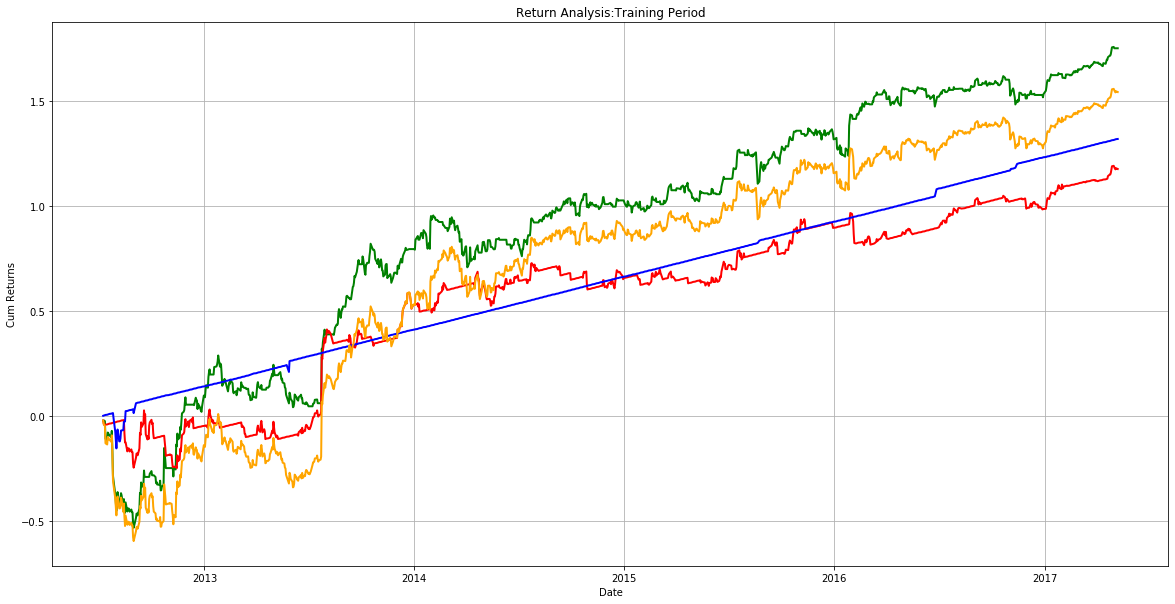

In [62]:
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(Rdata.index,Cum_Return,linewidth=2,color='green')
ax.plot(Rdata.index,Cum_MACD,linewidth=2,color='red')
ax.plot(Rdata.index,Cum_RSI,linewidth=2,color='blue')
ax.plot(Rdata.index,BH_Cum_Return,linewidth=2,color='orange')

ax.set(xlabel='Date',ylabel='Cum Returns',title='Return Analysis:Training Period')
ax.grid()
plt.show()

# Strategy Analysis:Test Period 

In [63]:
Testdata=df_daily[int(len(df_daily['Close'])*0.65):]
del Testdata['Next Week Move']

In [64]:
index=Testdata[['MACD','MHIST','RSI']]
inxclose=Testdata['Close']
predictions=model.predict(index)
Testdata['Predict']=predictions
Rdata=Testdata[['Close','Predict','MACD','MHIST','RSI']]
Rdata['NextClose']=Rdata['Close'].shift(-1)
Rdata.dropna(inplace=True)


In [65]:
Rdata['Strategy Return']=Rdata.apply(lambda x:np.log(x['NextClose']/x['Close']) if x['Predict']==1 else 0,axis=1)
Total_Return=Rdata['Strategy Return'].sum()
Cum_Return=Rdata['Strategy Return'].cumsum()
print("The Total Return for the Strategy is:",Total_Return)

The Total Return for the Strategy is: 0.25479646852681587


In [66]:
Rdata['MACD Return']=Rdata.apply(lambda x:np.log(x['NextClose']/x['Close']) if x['MACD']==1 else 0.001,axis=1)
Total_MACD=Rdata['MACD Return'].sum()
Cum_MACD=Rdata['MACD Return'].cumsum()
print("The Total Return for the MACD Strategy is:",Total_MACD)

The Total Return for the MACD Strategy is: 0.16675030393640855


In [67]:
Rdata['RSI Return']=Rdata.apply(lambda x:np.log(x['NextClose']/x['Close']) if x['RSI']==1 else 0.001,axis=1)
Total_RSI=Rdata['RSI Return'].sum()
Cum_RSI=Rdata['RSI Return'].cumsum()
print("The Total Return for the RSI Strategy is:",Total_RSI)

The Total Return for the RSI Strategy is: 0.7590121699573676


In [68]:
Rdata['Buy & Hold Returns']=np.log(Rdata['NextClose']/Rdata['Close'])
BH_Return=Rdata['Buy & Hold Returns'].sum()
BH_Cum_Return=Rdata['Buy & Hold Returns'].cumsum()
print('The Buy & Hold Strategy Return is:',BH_Return)

The Buy & Hold Strategy Return is: 0.275296183119435


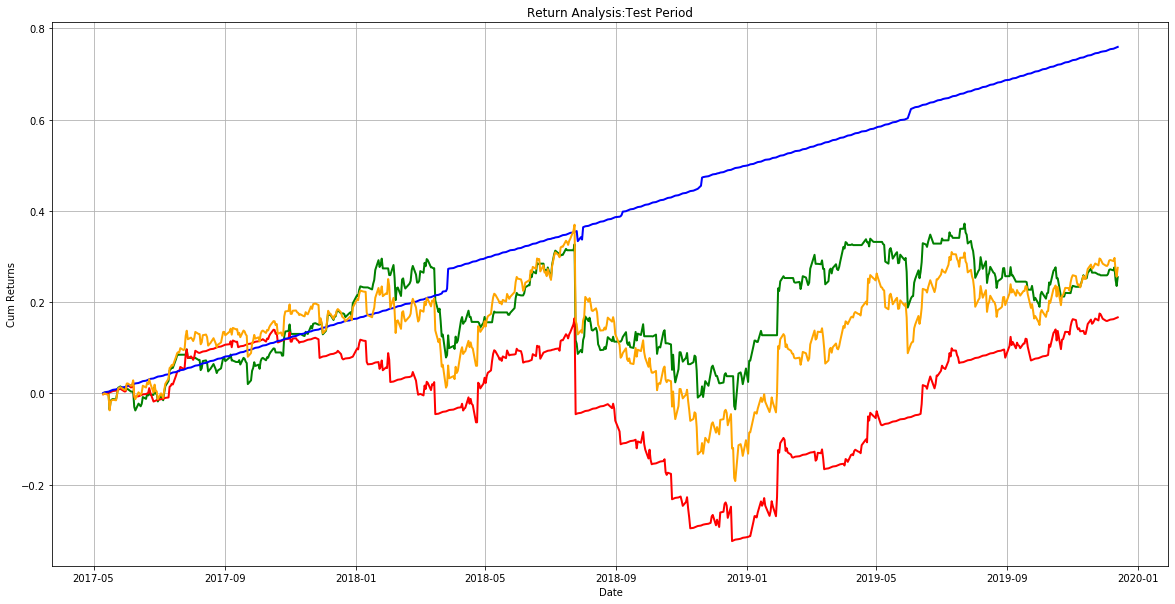

In [69]:
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(Rdata.index,Cum_Return,linewidth=2,color='green')
ax.plot(Rdata.index,Cum_MACD,linewidth=2,color='red')
ax.plot(Rdata.index,Cum_RSI,linewidth=2,color='blue')
ax.plot(Rdata.index,BH_Cum_Return,linewidth=2,color='orange')

ax.set(xlabel='Date',ylabel='Cum Returns',title='Return Analysis:Test Period')
ax.grid()
plt.show()